<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/PFNET_ParticleFlowGNN_TFKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLPF Demo

Cloned from J.R.Vlimant
https://github.com/vlimant/NNArchTeraScale2021/blob/master/graphs/mlParticleFlow.ipynb

credits to **Joosep Pata**. Model from the paper https://arxiv.org/abs/2101.08578 with more code available at https://github.com/jpata/particleflow

In [ ]:
!curl -O https://zenodo.org/record/4559324/files/tev14_pythia8_ttbar_0_0.pkl.bz2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.5M  100 47.5M    0     0  4327k      0  0:00:11  0:00:11 --:--:-- 5447k


In [ ]:
import bz2, pickle
import numpy as np
import tensorflow as tf
import sklearn.metrics
import matplotlib.pyplot as plt
import setGPU

setGPU: Setting GPU to: 0


In [ ]:
data = pickle.load(bz2.BZ2File("tev14_pythia8_ttbar_0_0.pkl.bz2", "r"))

In [ ]:
#100 events in one file
len(data["X"]), len(data["ygen"])

(100, 100)

In [ ]:
#Pad the number of elements to a size that's divisible by the bin size
Xs = []
ys = []

max_size = 50*128
for i in range(len(data["X"])):
    X = data["X"][i][:max_size, :]
    y = data["ygen"][i][:max_size, :]
    Xpad = np.pad(X, [(0, max_size - X.shape[0]), (0, 0)])
    ypad = np.pad(y, [(0, max_size - y.shape[0]), (0, 0)])
    Xpad = Xpad.astype(np.float32)
    ypad = ypad.astype(np.float32)
    Xs.append(Xpad)
    ys.append(ypad)
    
X = np.stack(Xs)
y = np.stack(ys)

In [ ]:
#Get the first event
input_classes = np.unique(X[:, :, 0].flatten())
output_classes = np.unique(y[:, :, 0].flatten())

In [ ]:
input_classes

array([0., 1., 2.], dtype=float32)

In [ ]:
output_classes

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [ ]:
#ygen = (pid, charge, momentum values)
num_momentum_outputs = data["ygen"][0].shape[1] - 2

# Model definition

In [ ]:
#Simple message passing based on a matrix multiplication
class PFNet(tf.keras.Model):
    def __init__(self,
        num_input_classes=8,
        num_output_classes=3,
        num_momentum_outputs=3,
        activation=tf.nn.selu,
        hidden_dim_id=256,
        hidden_dim_reg=256,
        distance_dim=256,
        convlayer="ghconv",
        dropout=0.1,
        bin_size=10,
        num_convs_id=1,
        num_convs_reg=1,
        num_hidden_id_enc=1,
        num_hidden_id_dec=1,
        num_hidden_reg_enc=1,
        num_hidden_reg_dec=1,
        num_neighbors=5,
        dist_mult=0.1,
        skip_connection=False):

        super(PFNet, self).__init__()
        self.activation = activation
        self.num_dists = 1
        self.num_momentum_outputs = num_momentum_outputs
        self.skip_connection = skip_connection

        encoding_id = []
        decoding_id = []
        encoding_reg = []
        decoding_reg = []

        #the encoder outputs and decoder inputs have to have the hidden dim (convlayer size)
        for ihidden in range(num_hidden_id_enc):
            encoding_id.append(hidden_dim_id)

        for ihidden in range(num_hidden_id_dec):
            decoding_id.append(hidden_dim_id)

        for ihidden in range(num_hidden_reg_enc):
            encoding_reg.append(hidden_dim_reg)

        for ihidden in range(num_hidden_reg_dec):
            decoding_reg.append(hidden_dim_reg)

        self.enc = InputEncoding(num_input_classes)
        self.layer_embedding = tf.keras.layers.Dense(distance_dim, name="embedding_attention", activation=self.activation)
        
        self.embedding_dropout = None
        if dropout > 0.0:
            self.embedding_dropout = tf.keras.layers.Dropout(dropout)

        self.dist = SparseHashedNNDistance(bin_size=bin_size, num_neighbors=num_neighbors, dist_mult=dist_mult)

        self.layer_edge = point_wise_feed_forward_network(1, 128, num_layers=2, activation=activation)

        convs_id = []
        convs_reg = []
        if convlayer == "sgconv":
            for iconv in range(num_convs_id):
                convs_id.append(SGConv(k=1, activation=activation, name="conv_id{}".format(iconv)))
            for iconv in range(num_convs_reg):
                convs_reg.append(SGConv(k=1, activation=activation, name="conv_reg{}".format(iconv)))
        elif convlayer == "ghconv":
            for iconv in range(num_convs_id):
                convs_id.append(GHConv(activation=activation, name="conv_id{}".format(iconv)))
            for iconv in range(num_convs_reg):
                convs_reg.append(GHConv(activation=activation, name="conv_reg{}".format(iconv)))

        self.gnn_id = EncoderDecoderGNN(encoding_id, decoding_id, dropout, activation, convs_id, name="gnn_id")
        self.layer_id = point_wise_feed_forward_network(num_output_classes, hidden_dim_id, num_layers=2, activation=activation)
        self.layer_charge = point_wise_feed_forward_network(1, hidden_dim_id, num_layers=1, activation=activation)
        
        self.gnn_reg = EncoderDecoderGNN(encoding_reg, decoding_reg, dropout, activation, convs_reg, name="gnn_reg")
        self.layer_momentum = point_wise_feed_forward_network(num_momentum_outputs, hidden_dim_reg, num_layers=2, activation=activation)

    # def create_model(self, num_max_elems, num_input_features, training=True):
    #     inputs = tf.keras.Input(shape=(num_max_elems, num_input_features,))
    #     return tf.keras.Model(inputs=[inputs], outputs=self.call(inputs, training), name="MLPFNet")

    def call(self, inputs, training=True):
        X = inputs
        msk_input = tf.expand_dims(tf.cast(X[:, :, 0] != 0, tf.dtypes.float32), -1)

        enc = self.enc(inputs)

        #embed inputs for graph structure prediction
        embedding_attention = self.layer_embedding(enc)
        if self.embedding_dropout:
            embedding_attention = self.embedding_dropout(embedding_attention, training)

        #create graph structure by predicting a sparse distance matrix
        dm = self.dist(embedding_attention, training)

        #gather node vals for src,dst
        i1 = tf.transpose(tf.stack([dm.indices[:, 0], dm.indices[:, 1]]))
        i2 = tf.transpose(tf.stack([dm.indices[:, 0], dm.indices[:, 2]]))
        x1 = tf.gather_nd(enc, i1)
        x2 = tf.gather_nd(enc, i2)

        #run an edge net on (src node, dst node, edge)
        edge_vals = self.layer_edge(tf.concat([x1, x2, tf.expand_dims(dm.values, axis=-1)], axis=-1))
        dm2 = tf.sparse.SparseTensor(indices=dm.indices, values=edge_vals[:, 0], dense_shape=dm.dense_shape)

        #run graph net for multiclass id prediction
        x_id = self.gnn_id(enc, dm2, training)
        
        if self.skip_connection:
            to_decode = tf.concat([enc, x_id], axis=-1)
        else:
            to_decode = tf.concat([x_id], axis=-1)

        out_id_logits = self.layer_id(to_decode)
        out_charge = self.layer_charge(to_decode)

        #run graph net for regression output prediction, taking as an additonal input the ID predictions
        x_reg = self.gnn_reg(tf.concat([enc, tf.cast(out_id_logits, X.dtype)], axis=-1), dm2, training)

        if self.skip_connection:
            to_decode = tf.concat([enc, tf.cast(out_id_logits, X.dtype), x_reg], axis=-1)
        else:
            to_decode = tf.concat([tf.cast(out_id_logits, X.dtype), x_reg], axis=-1)

        pred_momentum = self.layer_momentum(to_decode)

        return tf.concat([out_id_logits, out_charge, pred_momentum], axis=-1)

    def set_trainable_classification(self):
        for layer in self.layers:
            layer.trainable = False
        self.gnn_id.trainable = True
        self.layer_id.trainable = True

    def set_trainable_regression(self):
        for layer in self.layers:
            layer.trainable = False
        self.gnn_reg.trainable = True
        self.layer_momentum.trainable = True



## Sub-model definitions

In [ ]:
class InputEncoding(tf.keras.layers.Layer):
    def __init__(self, num_input_classes):
        super(InputEncoding, self).__init__()
        self.num_input_classes = num_input_classes

    """
        X: [Nbatch, Nelem, Nfeat] array of all the input detector element feature data
    """        
    @tf.function
    def call(self, X):

        #X[:, :, 0] - categorical index of the element type
        Xid = tf.cast(tf.one_hot(tf.cast(X[:, :, 0], tf.int32), self.num_input_classes), dtype=X.dtype)

        #X[:, :, 1:] - all the other non-categorical features
        Xprop = X[:, :, 1:]
        return tf.concat([Xid, Xprop], axis=-1)

In [ ]:
class SparseHashedNNDistance(tf.keras.layers.Layer):
    def __init__(self, max_num_bins=200, bin_size=500, num_neighbors=5, dist_mult=0.1, **kwargs):
        super(SparseHashedNNDistance, self).__init__(**kwargs)
        self.num_neighbors = tf.constant(num_neighbors)
        self.dist_mult = dist_mult

        #generate the codebook for LSH hashing at model instantiation for up to this many bins
        #set this to a high-enough value at model generation to take into account the largest possible input 
        self.max_num_bins = tf.constant(max_num_bins)

        #each bin will receive this many input elements, in total we can accept max_num_bins*bin_size input elements
        #in each bin, we will do a dense top_k evaluation
        self.bin_size = bin_size

    def build(self, input_shape):
        #(n_batch, n_points, n_features)

        #generate the LSH codebook for random rotations (num_features, max_num_bins/2)
        self.codebook_random_rotations = self.add_weight(
            shape=(input_shape[-1], self.max_num_bins//2), initializer="random_normal", trainable=False, name="lsh_projections"
        )

    @tf.function
    def call(self, inputs, training=True):

        #(n_batch, n_points, n_features)
        point_embedding = inputs

        n_batches = tf.shape(point_embedding)[0]
        n_points = tf.shape(point_embedding)[1]
        #points_neighbors = n_points * self.num_neighbors

        #cannot concat sparse tensors directly as that incorrectly destroys the gradient, see
        #https://github.com/tensorflow/tensorflow/blob/df3a3375941b9e920667acfe72fb4c33a8f45503/tensorflow/python/ops/sparse_grad.py#L33
        def func(args):
            ibatch, points_batch = args[0], args[1]
            inds, vals = self.construct_sparse_dm_batch(points_batch)
            inds = tf.concat([tf.expand_dims(tf.cast(ibatch, tf.int64)*tf.ones(tf.shape(inds)[0], dtype=tf.int64), -1), inds], axis=-1)
            return inds, vals

        elems = (tf.range(0, n_batches, delta=1, dtype=tf.int64), point_embedding)
        ret = tf.map_fn(func, elems, fn_output_signature=(tf.TensorSpec((None, 3), tf.int64), tf.TensorSpec((None, ), inputs.dtype)), parallel_iterations=2, back_prop=True)

        # #now create a new SparseTensor that is a concatenation of the per-batch tensor indices and values
        shp = tf.shape(ret[0])
        dms = tf.SparseTensor(
            tf.reshape(ret[0], (shp[0]*shp[1], shp[2])),
            tf.reshape(ret[1], (shp[0]*shp[1],)),
            (n_batches, n_points, n_points)
        )

        return tf.sparse.reorder(dms)

    @tf.function
    def subpoints_to_sparse_matrix(self, n_points, subindices, subpoints):

        #find the distance matrix between the given points using dense matrix multiplication
        dm = pairwise_dist(subpoints, subpoints)
        dm = tf.exp(-self.dist_mult*dm)

        dmshape = tf.shape(dm)
        nbins = dmshape[0]
        nelems = dmshape[1]

        #run KNN in the dense distance matrix, accumulate each index pair into a sparse distance matrix
        top_k = tf.nn.top_k(dm, k=self.num_neighbors)
        top_k_vals = tf.reshape(top_k.values, (nbins*nelems, self.num_neighbors))

        indices_gathered = tf.map_fn(
            lambda i: tf.gather_nd(subindices, top_k.indices[:, :, i:i+1], batch_dims=1),
            tf.range(self.num_neighbors, dtype=tf.int32)
        )
        indices_gathered = tf.transpose(indices_gathered, [1,2,0])

        def func(i):
           dst_ind = indices_gathered[:, :, i] #(nbins, nelems)
           dst_ind = tf.reshape(dst_ind, (nbins*nelems, ))
           src_ind = tf.reshape(tf.stack(subindices), (nbins*nelems, ))
           src_dst_inds = tf.cast(tf.transpose(tf.stack([src_ind, dst_ind])), dtype=tf.int64)
           return src_dst_inds, top_k_vals[:, i]

        ret = tf.map_fn(func, tf.range(0, self.num_neighbors, delta=1, dtype=tf.int32), fn_output_signature=(tf.int64, subpoints.dtype))
        
        shp = tf.shape(ret[0])
        inds = tf.reshape(ret[0], (shp[0]*shp[1], 2))
        vals = tf.reshape(ret[1], (shp[0]*shp[1],))
        return inds, vals

    def construct_sparse_dm_batch(self, points):
        #points: (n_points, n_features) input elements for graph construction
        n_points = tf.shape(points)[0]
        n_features = tf.shape(points)[1]

        #compute the number of LSH bins to divide the input points into on the fly
        #n_points must be divisible by bin_size exactly due to the use of reshape
        n_bins = tf.math.floordiv(n_points, self.bin_size)
        #tf.debugging.assert_greater(n_bins, 0)

        #put each input item into a bin defined by the softmax output across the LSH embedding
        mul = tf.linalg.matmul(points, self.codebook_random_rotations[:, :n_bins//2])

        cmul = tf.concat([mul, -mul], axis=-1)

        #cmul is now an integer in [0..nbins) for each input point
        #bins_split: (n_bins, bin_size) of integer bin indices, which put each input point into a bin of size (n_points/n_bins)
        bins_split = split_indices_to_bins(cmul, n_bins, self.bin_size)

        #parts: (n_bins, bin_size, n_features), the input points divided up into bins
        parts = tf.gather(points, bins_split)

        #sparse_distance_matrix: (n_points, n_points) sparse distance matrix
        #where higher values (closer to 1) are associated with points that are closely related
        sparse_distance_matrix = self.subpoints_to_sparse_matrix(n_points, bins_split, parts)

        return sparse_distance_matrix

In [ ]:
def split_indices_to_bins(cmul, nbins, bin_size):
    bin_idx = tf.argmax(cmul, axis=-1)
    bins_split = tf.reshape(tf.argsort(bin_idx), (nbins, bin_size))
    return bins_split

def pairwise_dist(A, B):  
    na = tf.reduce_sum(tf.square(A), -1)
    nb = tf.reduce_sum(tf.square(B), -1)

    # na as a row and nb as a column vectors
    na = tf.expand_dims(na, -1)
    nb = tf.expand_dims(nb, -2)

    # return pairwise euclidead difference matrix
    D = tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 1e-6))
    return D
def point_wise_feed_forward_network(d_model, dff, num_layers=1, activation='elu', dtype=tf.dtypes.float32):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(dff, activation=activation) for i in range(num_layers)] +
        [tf.keras.layers.Dense(d_model, dtype=dtype)]
    )

In [ ]:
"""
sp_a: (nbatch, nelem, nelem) sparse distance matrices
b: (nbatch, nelem, ncol) dense per-element feature matrices
"""
def sparse_dense_matmult_batch(sp_a, b):

    dtype = b.dtype
    b = tf.cast(b, tf.float32)

    num_batches = tf.shape(b)[0]

    def map_function(x):
        i, dense_slice = x[0], x[1]
        num_points = tf.shape(b)[1]
        sparse_slice = tf.sparse.reshape(tf.sparse.slice(
            tf.cast(sp_a, tf.float32), [i, 0, 0], [1, num_points, num_points]),
            [num_points, num_points])
        mult_slice = tf.sparse.sparse_dense_matmul(sparse_slice, dense_slice)
        return mult_slice

    elems = (tf.range(0, num_batches, delta=1, dtype=tf.int64), b)
    ret = tf.map_fn(map_function, elems, fn_output_signature=tf.TensorSpec((None, None), b.dtype), back_prop=True)
    return tf.cast(ret, dtype) 


In [ ]:
#https://arxiv.org/pdf/2004.04635.pdf
#https://github.com/gcucurull/jax-ghnet/blob/master/models.py 
class GHConv(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        self.activation = kwargs.pop("activation")

        super(GHConv, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.hidden_dim = input_shape[0][-1]
        self.nelem = input_shape[0][-2]
        self.W_t = self.add_weight(shape=(self.hidden_dim, self.hidden_dim), name="w_t", initializer="random_normal")
        self.b_t = self.add_weight(shape=(self.hidden_dim,), name="b_t", initializer="random_normal")
        self.W_h = self.add_weight(shape=(self.hidden_dim, self.hidden_dim), name="w_h", initializer="random_normal")
        self.theta = self.add_weight(shape=(self.hidden_dim, self.hidden_dim), name="theta", initializer="random_normal")
 
    #@tf.function
    def call(self, inputs):
        x, adj = inputs

        #compute the normalization of the adjacency matrix
        in_degrees = tf.sparse.reduce_sum(tf.abs(adj), axis=-1)
        in_degrees = tf.reshape(in_degrees, (tf.shape(x)[0], tf.shape(x)[1]))

        #add epsilon to prevent numerical issues from 1/sqrt(x)
        norm = tf.expand_dims(tf.pow(in_degrees + 1e-6, -0.5), -1)

        f_hom = tf.linalg.matmul(x, self.theta)
        f_hom = sparse_dense_matmult_batch(adj, f_hom*norm)*norm

        f_het = tf.linalg.matmul(x, self.W_h)
        gate = tf.nn.sigmoid(tf.linalg.matmul(x, self.W_t) + self.b_t)

        out = gate*f_hom + (1-gate)*f_het
        return self.activation(out)


In [ ]:
class EncoderDecoderGNN(tf.keras.layers.Layer):
    def __init__(self, encoders, decoders, dropout, activation, conv, **kwargs):
        super(EncoderDecoderGNN, self).__init__(**kwargs)
        name = kwargs.get("name")

        #assert(encoders[-1] == decoders[0])
        self.encoders = encoders
        self.decoders = decoders

        self.encoding_layers = []
        for ilayer, nunits in enumerate(encoders):
            self.encoding_layers.append(
                tf.keras.layers.Dense(nunits, activation=activation, name="encoding_{}_{}".format(name, ilayer)))
            if dropout > 0.0:
                self.encoding_layers.append(tf.keras.layers.Dropout(dropout))

        self.conv = conv

        self.decoding_layers = []
        for ilayer, nunits in enumerate(decoders):
            self.decoding_layers.append(
                tf.keras.layers.Dense(nunits, activation=activation, name="decoding_{}_{}".format(name, ilayer)))
            if dropout > 0.0:
                self.decoding_layers.append(tf.keras.layers.Dropout(dropout))

    @tf.function
    def call(self, inputs, distance_matrix, training=True):
        x = inputs

        for layer in self.encoding_layers:
            x = layer(x)

        for convlayer in self.conv:
            x = convlayer([x, distance_matrix])

        for layer in self.decoding_layers:
            x = layer(x)

        return x


In [ ]:
class PFNetLoss:
    def __init__(self, num_input_classes, num_output_classes, momentum_loss_coefs=[1.0, 1.0, 1.0], charge_loss_coef=1e-3):
        self.num_input_classes = num_input_classes
        self.num_output_classes = num_output_classes
        self.momentum_loss_coefs = tf.constant(momentum_loss_coefs)
        self.charge_loss_coef = charge_loss_coef

    def mse_unreduced(self, true, pred):
        return tf.math.pow(true-pred,2)

    def separate_prediction(self, y_pred):
        N = self.num_output_classes
        pred_id_logits = y_pred[:, :, :N]
        pred_charge = y_pred[:, :, N:N+1]
        pred_momentum = y_pred[:, :, N+1:]
        return pred_id_logits, pred_charge, pred_momentum

    def separate_truth(self, y_true):
        true_id = tf.cast(y_true[:, :, :1], tf.int32)
        true_charge = y_true[:, :, 1:2]
        true_momentum = y_true[:, :, 2:]
        return true_id, true_charge, true_momentum

    def loss_components(self, y_true, y_pred):
        pred_id_logits, pred_charge, pred_momentum = self.separate_prediction(y_pred)
        pred_id = tf.cast(tf.argmax(pred_id_logits, axis=-1), tf.int32)
        true_id, true_charge, true_momentum = self.separate_truth(y_true)
        true_id_onehot = tf.one_hot(tf.cast(true_id, tf.int32), depth=self.num_output_classes)

        l1 = tf.nn.softmax_cross_entropy_with_logits(true_id_onehot, pred_id_logits)
      
        l2 = self.mse_unreduced(true_momentum, pred_momentum) * self.momentum_loss_coefs
        l2s = tf.reduce_sum(l2, axis=-1)

        l3 = self.charge_loss_coef*self.mse_unreduced(true_charge, pred_charge)[:, :, 0]

        return l1, l2s, l3, l2

    def my_loss_full(self, y_true, y_pred):
        l1, l2, l3, _ = self.loss_components(y_true, y_pred)
        loss = l1 + l2 + l3

        return loss

    def my_loss_cls(self, y_true, y_pred):
        l1, l2, l3, _ = self.loss_components(y_true, y_pred)
        loss = l1

        return loss

    def my_loss_reg(self, y_true, y_pred):
        l1, l2, l3, _ = self.loss_components(y_true, y_pred)
        loss = l3

        return loss

In [ ]:
model = PFNet(
    num_input_classes=len(input_classes),
    num_output_classes=len(output_classes),
    num_momentum_outputs=num_momentum_outputs,
    activation=tf.nn.elu,
    bin_size=128,
    num_neighbors=16
)

#combined multiclass + regression loss
loss = PFNetLoss(
    num_input_classes=len(input_classes),
    num_output_classes=len(output_classes),
    
    #(pt, eta, sin phi, cos phi, E)
    momentum_loss_coefs=[0.001, 1.0, 1.0, 1.0, 0.001]
)

#temporal weight mode means each input element in the event can get a separate weight
model.compile(loss=loss.my_loss_full, optimizer="adam", sample_weight_mode="temporal")

In [ ]:
X.shape, y.shape

((100, 6400, 12), (100, 6400, 7))

In [ ]:
history = model.fit(X[:80], y[:80], validation_data=(X[80:], y[80:]), batch_size=5, epochs=1)

16/16 [==============================] - 9s 569ms/step - loss: 15.3928 - val_loss: 10.2743


In [ ]:
ypred = model.predict(X, batch_size=5)

In [ ]:
#index of the class prediction output values
pred_id_offset = len(output_classes)
ypred_ids_raw = ypred[:, :, :pred_id_offset]
ypred_charge = ypred[:, :, pred_id_offset:pred_id_offset+1]
ypred_momentum = ypred[:, :, pred_id_offset+1:]

The model is predicting the particle ID:
PID==0: no particle
PID==1: charged hadron
PID==2: neutral hadron
PID==3: photon
PID==4: electron
PID==5: muon

In [ ]:
CM = sklearn.metrics.confusion_matrix(
    np.argmax(ypred_ids_raw, axis=-1).flatten(),
    y[:, :, 0].flatten(), labels=output_classes
)
CM

array([[130133,     67,      0,      1,      0,      0],
       [   675, 247771,     26,    398,    646,    249],
       [ 12592,  12423,  89067,  16928,     41,     20],
       [  4174,   3735,   4415, 116405,    225,      9],
       [     0,      0,      0,      0,      0,      0],
       [     0,      0,      0,      0,      0,      0]])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


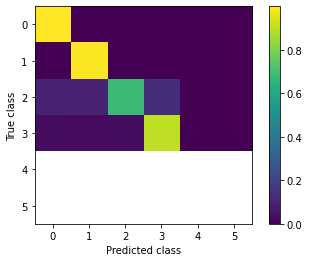

In [ ]:
CMN = CM /  CM.sum(axis=1)[:,np.newaxis]
plt.imshow(CMN)
plt.colorbar(orientation='vertical')
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

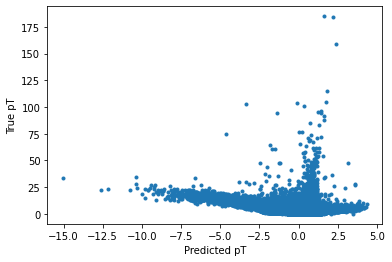

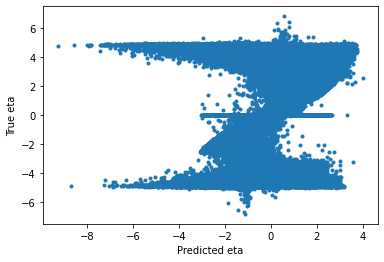

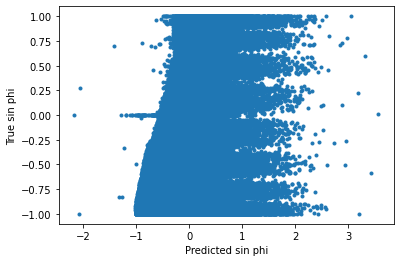

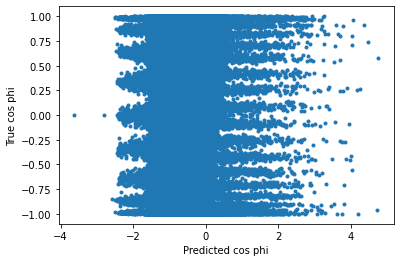

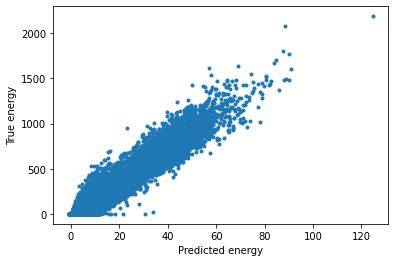

In [ ]:
#first two values in the y array are ID anc charge
momentum_offset = 2

#momentum eta component
for imomentum,label in enumerate(["pT", "eta", "sin phi","cos phi", "energy"]):
    plt.scatter(ypred_momentum[:, :, imomentum].flatten(), y[:, :, imomentum+momentum_offset].flatten(), marker=".")
    plt.xlabel("Predicted {}".format(label))
    plt.ylabel("True {}".format(label))
    plt.show()